In [6]:
from gradio_client import Client, handle_file   
# импорт contenxtmanager
from contextlib import contextmanager
import time
import os
from pydantic import BaseModel, Field
import csv
from rapidfuzz import process, fuzz
import re

from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json

In [2]:
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self  # возвращаем self, чтобы получить доступ к elapsed_time

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.time()
        self.elapsed = round(self.end - self.start,4)
        #print(f"Cell execution time: {self.elapsed:.4f} seconds")


In [3]:
with Timer() as t:
    time.sleep(1)

print(t.elapsed)

1.0001


In [4]:
DATA_BASE_DIR = "/home/jovyan/names"

In [5]:
# Get all jpg files
def get_all_files():
    files = []
    for root, dirs, filenames in os.walk(DATA_BASE_DIR):
        for filename in filenames:
            if filename.endswith(".jpg"):
                files.append(os.path.join(root, filename))
    return files

In [6]:
all_files = get_all_files()
all_files[:10]

['/home/jovyan/names/267.jpg',
 '/home/jovyan/names/879.jpg',
 '/home/jovyan/names/102.jpg',
 '/home/jovyan/names/861.jpg',
 '/home/jovyan/names/785.jpg',
 '/home/jovyan/names/162.jpg',
 '/home/jovyan/names/490.jpg',
 '/home/jovyan/names/872.jpg',
 '/home/jovyan/names/39.jpg',
 '/home/jovyan/names/797.jpg']

In [7]:
client = Client("http://api:7860/")

Loaded as API: http://api:7860/ ✔


In [8]:
SYSTEM_PROMPT = '''
Вы — ассистент, который извлекает информацию с русских товарных этикеток на изображениях. В тексте могут встречаться названия на английском.
Выведи Только текст, без лишних слов. Никаких объяснений.
'''

In [9]:
def  predict(file_path, model_name = "gemma3:4b"):    
    result = client.predict(
		system_prompt =SYSTEM_PROMPT,
		user_prompt="",
		image=handle_file(file_path),
        #image=None,
		selected_model=model_name,
		temperator=0.2,
		api_name="/predict"
	)
    return result

In [10]:


class PhraseCorrector:
    def __init__(self, words_file="words.csv",score_cutoff=70, min_len = 5):
        with open(words_file, "r", encoding="utf-8") as f:
            self.reference_words = [line.strip() for line in f]
        self.score_cutoff = score_cutoff
        self.min_len = min_len





    def correct_words_in_text(self,text):
        corrected_lines = []
        for line in text.strip().split('\n'):
            corrected_words = []
            words = re.split(r"[ \t\f\v.,!?;:()\"«»—–\-\/]+", line.upper().replace("Ё", "Е"))
            words = list(filter(None, words))  # убираем пустые строки, если они есть
        
            for word in words:
                if len(word) < self.min_len:
                    corrected_words.append(word)
                    continue
                # Ищем наиболее близкое слово из словаря
                match = process.extractOne(word, self.reference_words, scorer=fuzz.ratio, score_cutoff=self.score_cutoff)
                #print(match)
                corrected_word = match[0] if match else word
                corrected_words.append(corrected_word)
            corrected_lines.append(' '.join(corrected_words))
        return '\n'.join(corrected_lines)

In [11]:
phrase_corrector = PhraseCorrector("words.txt")

In [ ]:
class CSVRow(BaseModel):
    file_name: str
    text: str
    elapsed_time: float
    corrected_text: str
    elapsed_time_corrected: float


Process images:   0%|          | 0/10 [00:00<?, ?image/s]

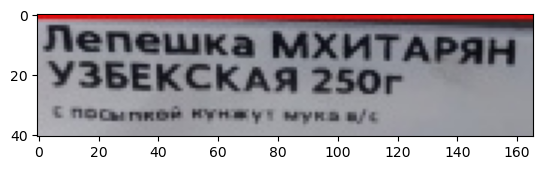

Process images:   0%|          | 0/10 [00:03<?, ?image/s]


KeyboardInterrupt: 

In [23]:
with open("results.tsv", "w", encoding="utf-8") as f:
    writer = csv.writer(f, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
    writer.writerow(CSVRow.model_fields.keys())
    

    for file_path in tqdm(all_files[200:210], desc="Process images", unit="image"):
        
        row = CSVRow(
            file_name="",
            text="",
            elapsed_time=0.0,
            corrected_text="",
            elapsed_time_corrected=0.0
        )
    
        file_name = os.path.basename(file_path)
        row.file_name = file_name
        
        img = mpimg.imread(file_path)
        plt.imshow(img)
        plt.show() 
        
        with Timer() as t:
            result = predict(file_path)
            #result = "_test_result_\n" + file_name + "\n" + "Тестовый результат"
        row.elapsed_time = t.elapsed
        row.text = result
        
        with Timer() as t:
            corrected_result = phrase_corrector.correct_words_in_text(result)
            #corrected_result = "_test_corrected_result_\n" + file_name + "\n" + "Тестовый исправленный результат"
        row.elapsed_time_corrected = t.elapsed
        row.corrected_text = corrected_result
        print(json.dumps(row.model_dump(), indent=4, ensure_ascii=False))
        writer.writerow(row.model_dump().values())
        f.flush()  
    

In [ ]:
df = pd.read_csv("results.tsv", sep="\t")
df.head(10)

,file_name,text,elapsed_time,corrected_text,elapsed_time_corrected
0,694.jpg,_test_result_,0.0,_test_corrected_result_,0.0
1,675.jpg,_test_result_,0.0,_test_corrected_result_,0.0
2,376.jpg,_test_result_,0.0,_test_corrected_result_,0.0
3,836.jpg,_test_result_,0.0,_test_corrected_result_,0.0
4,423.jpg,_test_result_,0.0,_test_corrected_result_,0.0
5,850.jpg,_test_result_,0.0,_test_corrected_result_,0.0
6,72.jpg,_test_result_,0.0,_test_corrected_result_,0.0
7,612.jpg,_test_result_,0.0,_test_corrected_result_,0.0
8,268.jpg,_test_result_,0.0,_test_corrected_result_,0.0
9,18.jpg,_test_result_,0.0,_test_corrected_result_,0.0


# Дополнение результата колонком с оригинальным текстом

In [17]:
saved_xlsx = "https://docs.google.com/spreadsheets/d/1E92a3fsSQM_Lp13hjONme5aGaWTxRYcWBQussVfE8yE/export?format=xlsx"


In [18]:
!wget -O results.xlsx $saved_xlsx

--2025-04-24 10:17:13--  https://docs.google.com/spreadsheets/d/1E92a3fsSQM_Lp13hjONme5aGaWTxRYcWBQussVfE8yE/export?format=xlsx
Resolving docs.google.com (docs.google.com)... 216.58.211.238, 2a00:1450:4026:808::200e
Connecting to docs.google.com (docs.google.com)|216.58.211.238|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-08-1s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/n8skbugnht4jk3ksslp2bm6q8g/1745489830000/117963286932567830463/*/1E92a3fsSQM_Lp13hjONme5aGaWTxRYcWBQussVfE8yE?format=xlsx [following]
--2025-04-24 10:17:13--  https://doc-08-1s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/n8skbugnht4jk3ksslp2bm6q8g/1745489830000/117963286932567830463/*/1E92a3fsSQM_Lp13hjONme5aGaWTxRYcWBQussVfE8yE?format=xlsx
Resolving doc-08-1s-sheets.googleusercontent.com (doc-08-1s-sheets.googleusercontent.com)... 216.58.211.225, 2a00:1450:4026:808::2001
Connecting to doc-08-1s-sheets.googleusercontent.com

In [19]:
df = pd.read_excel("results.xlsx")

In [20]:
df.head(10)

,file_name,text,elapsed_time,corrected_text,elapsed_time_corrected,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,Вода СВЯТОЙ ИСТОЧНИК\n1.0л\nПригодна пить всем,5.1053,ВОДА СВЯТОЙ ИСТОЧНИК\n1 0Л\nПРИРОДНАЯ ПИТЬ ВСЕМ,0.0004,NaN,NaN,NaN
1,2,"Вода Святой источник\n0,75л\nнегазированная вода",4.2579,ВОДА СВЯТОЙ ИСТОЧНИК\n0 75Л\nНЕГАЗИРОВАННАЯ ВОДА,0.0004,NaN,NaN,NaN
2,3,Вода ШИШКИН ЛЕС\nпитьевая 1л\nАО «Заирoколина»,5.2103,ВОДА ШИШКИН ЛЕС\nПИТЬЕВАЯ 1Л\nАО ЗАИРOКОЛИНА,0.0006,NaN,NaN,NaN
3,4,Цена красная,3.4990,ЦЕНА КРАСНАЯ,0.0001,NaN,NaN,NaN
4,5,Вода Святой Источник\n1.5л\nх.почечен. без сах...,5.0172,ВОДА СВЯТОЙ ИСТОЧНИК\n1 5Л\nХ ПЕЧЕН БЕЗ САХ ПИЛ Б,0.0005,NaN,NaN,NaN
5,6,Пода СНЕЖСКАЯ \nпитьевая 1.5л,4.6530,ПОДА СЕНЕЖСКАЯ\nПИТЬЕВАЯ 1 5Л,0.0003,вода,NaN,NaN
6,7,Чипсы LAY'S\n120г\nВкус Красная Икра,4.6045,ЧИПСЫ LAYS\n120Г\nВКУС КРАСНАЯ ИКРА,0.0003,lay's,NaN,NaN
7,8,Lay's\n105г\nнат.кар/риб.акл.ребеш.cn/n.c.,5.4041,LAYS\n105Г\nНАТ КАР РИБ АКЛ ГРЕБЕШ CN N C,0.0006,NaN,NaN,NaN
8,9,Чипсы РУССКАЯ КАРТОШКА\n190г \nкартофель со вк...,5.7602,ЧИПСЫ РУССКАЯ КАРТОШКА\n190Г\nКАРТОФЕЛЬ СО ВКУ...,0.0003,NaN,NaN,NaN
9,10,Чипсы LAYS 85г\nкар.со вкус.лысички в сметане,4.7511,ЧИПСЫ LAYS 85Г\nКАР СО ВКУС ЛИСИЧКИ В СМЕТАНЕ,0.0005,lays,NaN,NaN
